Universidade Federal do Rio Grande do Sul (UFRGS)   
Programa de Pós-Graduação em Engenharia Civil (PPGEC)   

# PEC00144: Experimental Methods in Civil Engineering

### Reading the serial port of an Arduino device  

---
_Prof. Marcelo M. Rocha, Dr.techn._ [(ORCID)](https://orcid.org/0000-0001-5640-1020)  
_Porto Alegre, RS, Brazil_ 


In [1]:
# Importing Python modules required for this notebook
# (this cell must be executed with "shift+enter" before any other Python cell)

import sys
import time
import serial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from   MRPy  import MRPy

#Ardn.close()

### 1. Setup serial communication

In order to run this notebook, the Python module ``pyserial`` must be installed.
To ensure the module availability, open a conda terminal and issue the command:

    conda install -c anaconda pyserial

Before openning the serial port, verify with Arduino IDE which USB identifier the 
board has be assigned (in Windows it has the form "COMxx", while in Linux it
it is something like "/dev/ttyXXXX").


In [2]:
#port  = '/dev/ttyUSB0' 
#baud  =  9600

port   = 'COM5'           # change this address according to your computer
baud   =  115200          # match this number with the Arduino's output baud rate

Ardn  =  serial.Serial(port, baud, timeout=1)

time.sleep(3)             # this is important to give time for serial settling

### 2. Define function for reading one incoming line

In [3]:
def ReadSerial(nchar, nvar, nlines=1):

    Ardn.write(str(nlines).encode())
    data = np.zeros((nlines,nvar))

    for k in range(nlines):
        
        wait = True
        while(wait):
          
            if (Ardn.inWaiting() >= nchar):
                bdat = Ardn.readline() 
                sdat = bdat.decode()
                sdat = sdat.replace('\n',' ').split()
                wait = False
            
                data[k, :] = np.array(sdat[0:nvar], dtype='int')
        
    return data


### 3. Acquire data lines from serial port

In [4]:
try:
    data = ReadSerial(30, 4, nlines=3679)
    t    = data[:,0 ]
    dat  = data[:,1:]

    Ardn.close()
    print('Acquisition ok!')
    
except:
    Ardn.close()
    sys.exit('Acquisition failure!')

Acquisition ok!


### 4. Create ``MRPy`` instance and save to file 

In [5]:
ti  = (t - t[0])/1000

A   =  (dat/16618.05902169)*9.81

# A = dat

# data = MRPy.resampling(ti, A)
data = MRPy.resampling(ti, A).zero_mean()
data.to_file('DATA/med_6X', form='excel')

print('Average sampling rate is {0:5.1f}Hz.'.format(data.fs))

print(data.mean(axis=1))

Average sampling rate is 367.9Hz.
[-1.00270415e-17 -1.87251979e-18 -1.25929976e-15]


In [6]:
data.Td

9.992281751427793

In [7]:
data.fs

367.8839419709855

### 5. Data visualization

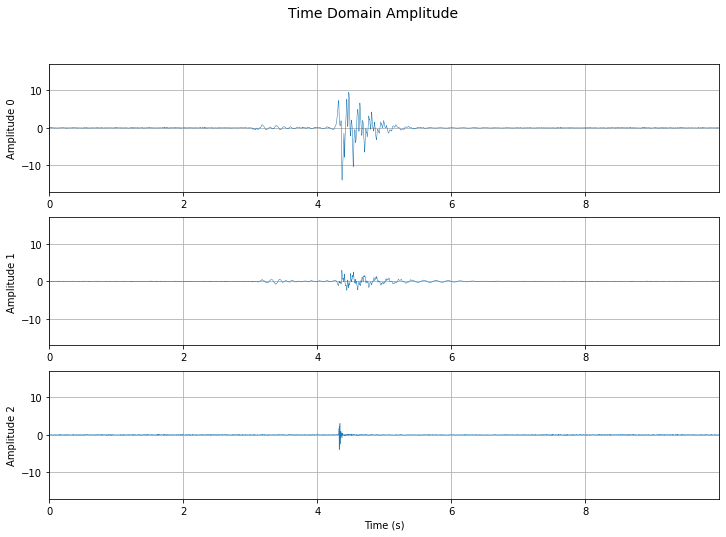

In [8]:
# %matplotlib qt
%matplotlib inline 

lim_sup = 17.
lim_inf = -17.

fig1 = data.plot_time(fig=1, figsize=(12,8), axis_t=[0, data.Td, lim_inf, lim_sup])


### EXTRAIR A FAIXA DE INTERESSE DO GRÁFICO

In [ ]:
free = data.extract((2.7, 5.5), by='time')

free.printAttrib()
free.plot_time(fig=2);


### AJUSTAR O SINAL "FIT DECAY"

In [ ]:
# %matplotlib qt
afit, par = free.fit_decay()
t         = free.t_axis()               # prepare time axis for plotting
plt.figure(3, figsize=(12, 6), clear=True)
plt.plot(t, free[0])
plt.plot(t, afit[0], 'r:')
plt.legend(('original','fitted'))

plt.xlim( 0, 2.);  plt.xlabel('time (s)') 
plt.ylim(lim_inf, lim_sup);  plt.ylabel('a(t)') 

plt.grid(True) 

print('Amplitude:     {0:4.2f} m/s²'.format(par[1,0]))
print('Frequency:     {0:4.2f}Hz  '.format(par[1,1]))
print('Damping ratio: {0:4.2f}%   '.format(par[1,2]*100))
print('Phase:         {0:4.2f}rad '.format(par[1,3]))


### PERIODOGRAMA

In [ ]:
# %matplotlib qt
%matplotlib inline 

fig2 = data.plot_freq(fig=4, figsize=(8,4), axis_f=[0, data.fs, 0, 3])

### ESPECTRO DE POTÊNCIA

In [ ]:
# %matplotlib qt
%matplotlib inline 

f12  = afit.plot_freq(5, figsize=(8,4)) # resolução alterada